# Cross correlation with WISE Catalog 

In [1]:
import sys, os
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def reddening_cat(cat, reddening_map = None):
    
    reddening = reddening_map
    
    cathpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest=False)
    mind = np.arange(hp.nside2npix(4096))
    reliable_hp_mask = (reddening < 0.05/0.367)
    reliable_hpind = mind[reliable_hp_mask]
    reliable_mask = np.in1d(cathpind, reliable_hpind)
    
    print cat.size,
    cat = cat[reliable_mask]
    print cat.size
    
    return cat

In [3]:
def BOSSveto(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

In [4]:
def moon_cont_mask(cat):
    
    mask = np.zeros(cat.size, dtype = 'bool') #(cat['MOON_LEV']=='0000')
    #combinations = []
    for i in [0,1,2]:
        for j in [0,1,2]:
            for k in [0,1,2]:
                for l in [0,1,2]:
                    filt = '{}{}{}{}'.format(i,j,k,l)
                    mask +=(cat['MOON_LEV']==filt)
    return mask
 

In [5]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal*1./pixarea    
    Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT_RAND'] = unseen
    return Map

In [6]:
#from astropy.table import Table
#t = Table.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.tbl', format='ipac')
#t.write('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits', format='fits', overwrite=True)

# Calling DES-CMASS

In [7]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
inputdir = rootdir
figoutdir = inputdir+'/figure/'
sysoutdir = inputdir+'/sys/'
actdir = inputdir + '/act/'
wdir = sysoutdir+'/weights/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+sysoutdir)
os.system('mkdir '+wdir)
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

256

In [8]:
dmass_spt = io.SearchAndCallFits(path= rootdir, keyword='dmass_spt_sys_v3.fits')
dmass_random_masked = io.SearchAndCallFits(path= rootdir, keyword='random_x50_dmass_spt_masked.fits')
dmass_random = io.SearchAndCallFits(path= rootdir, keyword='random_x50_dmass_spt.fits')
#dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 30 ))

dmass_spt = appendColumn(dmass_spt, name = 'WEIGHT', value = np.ones(dmass_spt.size))
dmass_spt['WEIGHT'] = dmass_spt['CMASS_PROB'] * dmass_spt['WEIGHT_SYS']
dmass_spt = dmass_spt[dmass_spt['CMASS_PROB'] > 0.01 ]


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits

--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt_masked.fits

--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt.fits


# Calling CMASS

In [9]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass = esutil.io.read([path+'galaxy_DR12v5_CMASS_South.fits.gz',
                        #path+'galaxy_DR12v5_CMASS_North.fits.gz'
                       ], combine=True)
random = esutil.io.read([path+'random0_DR12v5_CMASS_South.fits.gz',
                         #path+'random0_DR12v5_CMASS_North.fits.gz'
                        ], combine=True)

cmass_ngc = esutil.io.read([#path+'galaxy_DR12v5_CMASS_South.fits.gz',
                        path+'galaxy_DR12v5_CMASS_North.fits.gz'
                       ], combine=True)
random_ngc = esutil.io.read([#path+'random0_DR12v5_CMASS_South.fits.gz',
                         path+'random0_DR12v5_CMASS_North.fits.gz'
                        ], combine=True)

In [54]:
#cmass = BOSSveto(cmass, option='SGC')
#random = BOSSveto(random, option='SGC')

#cmass_ngc = BOSSveto(cmass_ngc, option='NGC')
#random_ngc = BOSSveto(random_ngc, option='NGC')

In [9]:
#randind = np.random.choice(cmass.size, size = 1000)

In [18]:
#random = construct_jk_catalog( random, njack = 10, root='./test/', 
#                           jtype = 'generate', jfile = 'jkregion_test.txt', suffix = '', retind=True )

X (13234, 2)  centers (10, 2)  tol=1e-05  maxiter=200
66 iterations  cluster sizes: [1331 1327 1112 1317 1225 1508 1340 1567 1112 1395]
X (43787993, 2)  centers (10, 2)  tol=1e-05  maxiter=200


KeyboardInterrupt: 

# Calling WISE Extended source catalog

In [10]:
wise = esutil.io.read('/n/des/lee.5922/data/wise_cat/wise_allsky.allsky_4band_p3as_psd25158.fits', upper=True)
wise_random_sgc = uniform_random_on_sphere(cmass, size = cmass.size * 50 )
wise_random_ngc = uniform_random_on_sphere(cmass_ngc, size = cmass_ngc.size * 50 )

In [11]:
#wise_in_cmass = BOSSveto(wise, option='SGC')
cont_mask = moon_cont_mask(wise)
wise = wise[cont_mask]
#wise_random_in_cmass = BOSSveto(wise_random_in_cmass, option='SGC')

In [12]:
#wise_ngc = BOSSveto(wise, option='NGC')

In [13]:
#wise_ngc.size, cmass_ngc.size

# Masking Reddening

In [14]:
mapname = '/n/des/lee.5922/data/systematic_maps/ebv_sfd98_fullres_nside_4096_nest_equatorial.fits'
#mapname = '/n/des/lee.5922/data/systematic_maps/ebv_lenz17_nside_4096_nest_equatorial.fits'
reddening = hp.read_map(mapname)
#hpIndices = np.arange(reddening_ring.size)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [15]:
wise = reddening_cat(wise, reddening_map = reddening)
wise_random_sgc = reddening_cat(wise_random_sgc, reddening_map = reddening)
wise_random_ngc = reddening_cat(wise_random_ngc, reddening_map = reddening)
#cmass = reddening_cat(cmass, reddening_map = reddening)
#random = reddening_cat(random, reddening_map = reddening)
#dmass_spt = reddening_cat(dmass_spt, reddening_map = reddening)
#dmass_random = reddening_cat(dmass_random, reddening_map = reddening)

3458881 2007810
11541550 8161608
30940300 30215041


# Boss veto

In [16]:
wise_in_sgc = BOSSveto(wise, option='SGC')
wise_in_ngc = BOSSveto(wise, option='NGC')
wise_random_sgc = BOSSveto(wise_random_sgc, option='SGC')
wise_random_ngc = BOSSveto(wise_random_ngc, option='NGC')

# Moon Contamination Masking

In [17]:
Healpix_config = {}
Healpix_config['out_nside'] = 128
Healpix_config['nest'] = False

wise_in_sgc = HealPixifyCatalogs(catalog=wise_in_sgc, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
wise_in_ngc = HealPixifyCatalogs(catalog=wise_in_ngc, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')

wise_random_sgc = HealPixifyCatalogs(catalog=wise_random_sgc, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
wise_random_ngc = HealPixifyCatalogs(catalog=wise_random_ngc, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')


#cmass = HealPixifyCatalogs(catalog=cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#random = HealPixifyCatalogs(catalog=random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_spt = HealPixifyCatalogs(catalog=dmass_spt, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_random = HealPixifyCatalogs(catalog=dmass_random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')

In [18]:
# obtain moon contamination mask from wise catalog 
wise_in_combine = np.hstack([wise_in_sgc, wise_in_ngc])
wise_galmap = making_healpix_density_map(cat = wise_in_combine, nest = False, nside = 128)
reliable_hpind_moonrev = wise_galmap['PIXEL'][ wise_galmap['WEIGHT_RAND'] ==1 ]
wise_in_combine = None

/usr/lib64/python2.7/site-packages/healpy/pixelfunc.py:390: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside,theta,phi)


In [19]:
#fitsio.write('/n/des/lee.5922/data/wise_cat/hpind_moonrev_nside256.fits', reliable_hpind_moonrev)

In [20]:
reliable_wise_mask = np.in1d(wise_in_sgc['HEALIndex'], reliable_hpind_moonrev)
wise_in_sgc = wise_in_sgc[reliable_wise_mask]


reliable_wise_mask = np.in1d(wise_in_ngc['HEALIndex'], reliable_hpind_moonrev)
wise_in_ngc = wise_in_ngc[reliable_wise_mask]


reliable_wise_random_sgc_mask = np.in1d(wise_random_sgc['HEALIndex'], reliable_hpind_moonrev)
wise_random_sgc = wise_random_sgc[reliable_wise_random_sgc_mask]

reliable_wise_random_ngc_mask = np.in1d(wise_random_ngc['HEALIndex'], reliable_hpind_moonrev)
wise_random_ngc = wise_random_ngc[reliable_wise_random_ngc_mask]



"""
reliable_cmass_mask = np.in1d(cmass['HEALIndex'], reliable_hpind_moonrev)
print 'cmass:', cmass.size, 
cmass = cmass[reliable_cmass_mask]
print cmass.size

reliable_random_mask = np.in1d(random['HEALIndex'], reliable_hpind_moonrev)
print 'random:', random.size,
random = random[reliable_random_mask]
print random.size

reliable_dmass_spt_mask = np.in1d(dmass_spt['HEALIndex'], reliable_hpind_moonrev)
print 'dmass_spt:', dmass_spt.size, 
dmass_spt = dmass_spt[reliable_dmass_spt_mask]
print dmass_spt.size

reliable_dmass_random_mask = np.in1d(dmass_random['HEALIndex'], reliable_hpind_moonrev)
print 'dmass_random:', dmass_random.size, 
dmass_random = dmass_random[reliable_dmass_random_mask]
print dmass_random.size
"""

"\nreliable_cmass_mask = np.in1d(cmass['HEALIndex'], reliable_hpind_moonrev)\nprint 'cmass:', cmass.size, \ncmass = cmass[reliable_cmass_mask]\nprint cmass.size\n\nreliable_random_mask = np.in1d(random['HEALIndex'], reliable_hpind_moonrev)\nprint 'random:', random.size,\nrandom = random[reliable_random_mask]\nprint random.size\n\nreliable_dmass_spt_mask = np.in1d(dmass_spt['HEALIndex'], reliable_hpind_moonrev)\nprint 'dmass_spt:', dmass_spt.size, \ndmass_spt = dmass_spt[reliable_dmass_spt_mask]\nprint dmass_spt.size\n\nreliable_dmass_random_mask = np.in1d(dmass_random['HEALIndex'], reliable_hpind_moonrev)\nprint 'dmass_random:', dmass_random.size, \ndmass_random = dmass_random[reliable_dmass_random_mask]\nprint dmass_random.size\n"

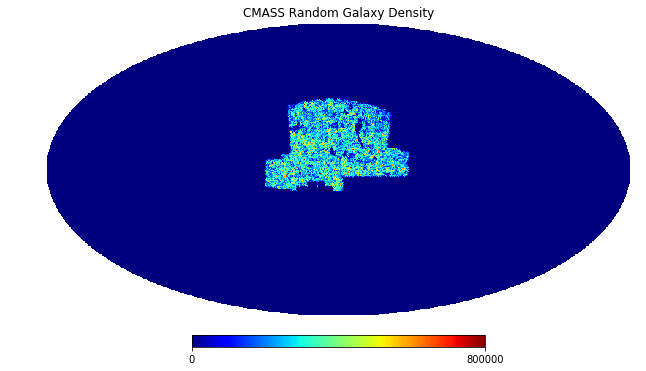

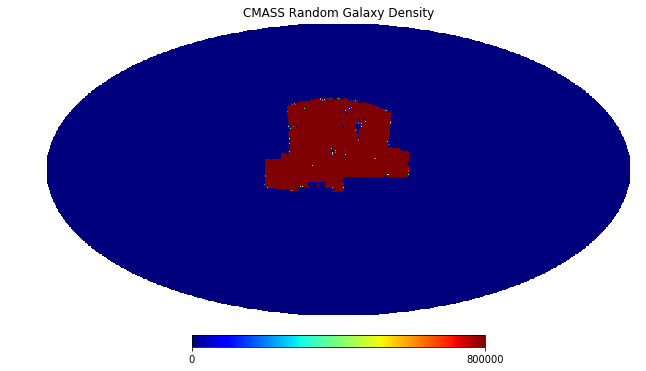

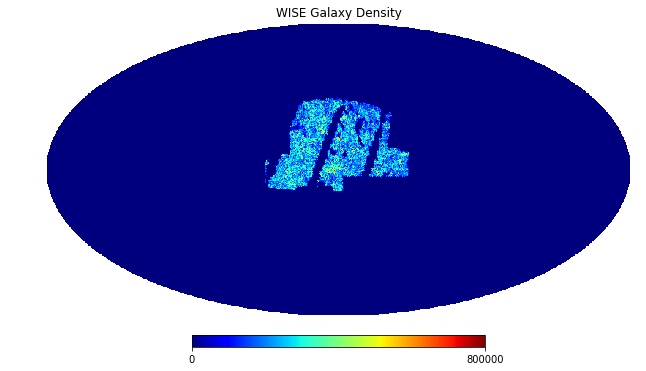

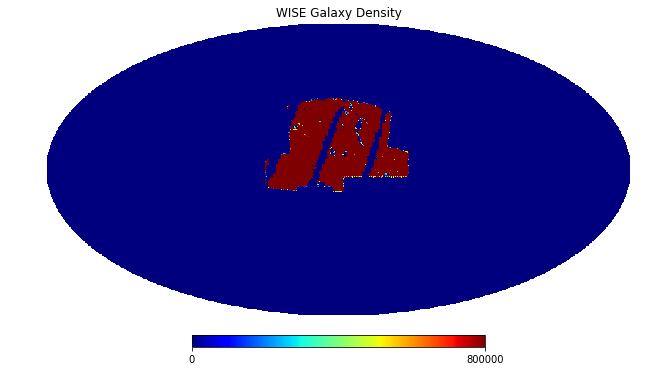

In [18]:
cmass_galmap = making_healpix_density_map(cat = cmass, nest = False, nside = 128)
hp.mollview(cmass_galmap['WEIGHT'],  nest=False, title="CMASS Random Galaxy Density", max = 8e+05)

random_galmap = making_healpix_density_map(cat = random, nest = False, nside = 128)
hp.mollview(random_galmap['WEIGHT'],  nest=False, title="CMASS Random Galaxy Density", max = 8e+05)

wise_in_cmass_galmap = making_healpix_density_map(cat = wise_in_sgc, nest = False, nside = 128)
hp.mollview(wise_in_cmass_galmap['WEIGHT'], nest=False, title="WISE Galaxy Density", max = 8e+05)

wise_random_in_cmass_galmap = making_healpix_density_map(cat = wise_random_sgc, nest = False, nside = 128)
hp.mollview(wise_random_in_cmass_galmap['WEIGHT'], nest=False, title="WISE Galaxy Density", max = 8e+05)

# Masking Boss Area

# Masking DES area

In [70]:
#Healpix_config = {}
#Healpix_config['out_nside'] = 4096
#Healpix_config['nest'] = False
#wise = HealPixifyCatalogs(catalog=wise, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#wise_random_in_cmass = HealPixifyCatalogs(catalog=wise_random_in_cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#cmass = HealPixifyCatalogs(catalog=cmass, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#random = HealPixifyCatalogs(catalog=random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_spt = HealPixifyCatalogs(catalog=dmass_spt, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
#dmass_random = HealPixifyCatalogs(catalog=dmass_random, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')

In [26]:
wise_in_spt = Cuts.keepGoodRegion(wise)
wise_in_spt = wise_in_spt[wise_in_spt['DEC'] < -3.0 ]
print 'wise:', wise.size, wise_in_spt.size

wise_random_in_spt = dmass_random.copy()

wise: 2007810 103569


In [27]:
# obtain moon contamination mask from wise catalog 
wise_galmap = making_healpix_density_map(cat = wise_in_spt, nest = False, nside = 128)
reliable_hpind_moonrev = wise_galmap['PIXEL'][ wise_galmap['WEIGHT_RAND'] ==1 ]

Healpix_config = {}
Healpix_config['out_nside'] = 128
Healpix_config['nest'] = False

wise_in_spt = HealPixifyCatalogs(catalog=wise_in_spt, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
reliable_wise_mask = np.in1d(wise_in_spt['HEALIndex'], reliable_hpind_moonrev)
wise_in_spt = wise_in_spt[reliable_wise_mask]

wise_random_in_spt = HealPixifyCatalogs(catalog=wise_random_in_spt, healConfig=Healpix_config, ratag='RA', dectag = 'DEC')
reliable_wise_mask = np.in1d(wise_random_in_spt['HEALIndex'], reliable_hpind_moonrev)
wise_random_in_spt = wise_random_in_spt[reliable_wise_mask]

wise_random_in_spt = reddening_cat(wise_random_in_spt, reddening_map = reddening)


21359047 21354092


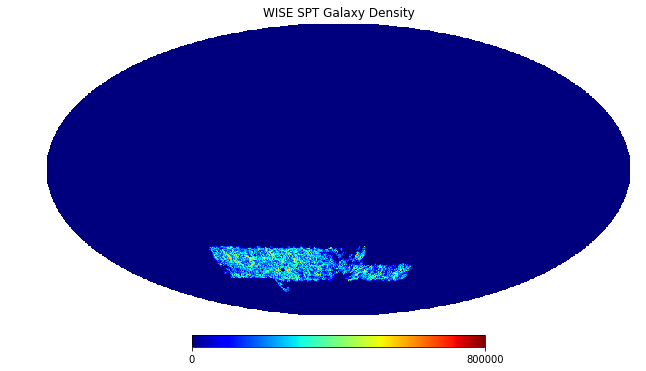

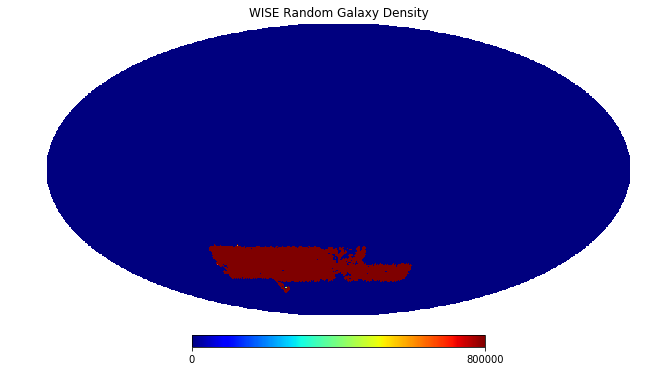

In [21]:
galmap = making_healpix_density_map(cat = wise_in_spt, nest = False, nside = 128)
hp.mollview(galmap['WEIGHT'],  nest=False, title="WISE SPT Galaxy Density", max = 8e+05)

galmap = making_healpix_density_map(cat = wise_random_in_spt, nest = False, nside = 128)
hp.mollview(galmap['WEIGHT'],  nest=False, title="WISE Random Galaxy Density", max = 8e+05)

# Adding Weight Column

In [21]:
w_sgc = cmass['WEIGHT_SYSTOT']*( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] - 1. )
w_rand = np.ones(random.size)

cmass = appendColumn(cat = cmass, name='WEIGHT', value=w_sgc)
random = appendColumn(cat = random, name='WEIGHT_RAND', value=w_rand)
#appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB']*dmass['WEIGHT_SYS'])

w_wise = np.ones(wise_in_sgc.size)
w_wise_rand = np.ones(wise_random_sgc.size)
wise_in_sgc = appendColumn(cat = wise_in_sgc, name='WEIGHT', value=w_wise)
wise_random_sgc = appendColumn(cat = wise_random_sgc, name='WEIGHT_RAND', value=w_wise_rand)

In [22]:
w_ngc = cmass_ngc['WEIGHT_SYSTOT']*( cmass_ngc['WEIGHT_CP'] + cmass_ngc['WEIGHT_NOZ'] - 1. )
w_rand = np.ones(random_ngc.size)

cmass_ngc = appendColumn(cat = cmass_ngc, name='WEIGHT', value=w_ngc)
random_ngc = appendColumn(cat = random_ngc, name='WEIGHT_RAND', value=w_rand)
#appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB']*dmass['WEIGHT_SYS'])

w_wise = np.ones(wise_in_ngc.size)
w_wise_rand = np.ones(wise_random_ngc.size)
wise_in_ngc = appendColumn(cat = wise_in_ngc, name='WEIGHT', value=w_wise)
wise_random_ngc = appendColumn(cat = wise_random_ngc, name='WEIGHT_RAND', value=w_wise_rand)

In [31]:
print 'catalog size cmass', cmass.size, random.size
print 'catalog size dmass', np.sum(dmass_spt['WEIGHT']), dmass_random.size
print 'catalog size wise(cmass)', wise_in_sgc.size, wise_random_sgc.size
print 'catalog size wise', wise_in_spt.size, wise_random_in_spt.size



catalog size cmass 230831 11636252
catalog size dmass 114774.39081275926 21412102
catalog size wise(cmass) 165483 1488393
catalog size wise 103569 21354092


# Cross Correlation

In [64]:
from systematics_module.corr import cross_NNpairCount

In [26]:
from systematics_module.corr import cross_NNpairCount
cross_NNpairCount(cmass, random, wise_in_sgc, wise_random_sgc, nbins = 10, 
                  min_sep=2.5/60., max_sep=250/60., bin_slop=0.05, 
                  weight = [True, True, True, True], 
                  dir = actdir, suffix = 'wise_x_cmass_sgc_nbins10_binslop05')

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_sgc_nbins10_binslop05.txt


In [27]:
from systematics_module.corr import cross_NNpairCount
cross_NNpairCount(cmass_ngc, random_ngc, wise_in_ngc, wise_random_ngc, nbins = 10, 
                  min_sep=2.5/60., max_sep=250/60., bin_slop=0.05, 
                  weight = [True, True, True, True], 
                  dir = actdir, suffix = 'wise_x_cmass_ngc_nbins10_binslop05')

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_ngc_nbins10_binslop05.txt


In [28]:


cross_NNpairCount(dmass_spt, dmass_random_masked[randind], wise_in_spt, wise_random_in_spt[randind2], nbins = 10, 
                  min_sep=2.5/60., max_sep=250/60., bin_slop=0.05, 
                  weight = [True, None, None, None], 
                  dir = actdir, suffix = 'wise_x_dmass_nbins10_binslop05')

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_dmass_nbins10_binslop05.txt


In [32]:
print wise_in_sgc.size
wise_in_sgc.size / 2422.64856426 / 3600

165483


0.01897406857855209

In [35]:
print wise_in_spt.size
wise_in_spt.size/1260.9130947509416 /3600.

103569


0.0228161375961832

In [37]:
print wise_in_ngc.size
print wise_in_ngc.size/6934./3600.

500064
0.0200326891645


In [ ]:
from systematics_module.corr import cross_angular_correlation

cross_angular_correlation(data = cmass, 
                          data2 = wise_in_sgc, 
                          rand = random, 
                          rand2= wise_random_sgc,
                          njack = 100, nbins=10, bin_slop=0.05,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_sgc_nbins10_binslop05_jk100')



X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [ 6 11  9 15 15  8 14  6 20  7 10 10 11  8 16  6  9 12  9 13  2 11  7 10
 14 10 10 15 10  9  5  5 12 16 20 15  9 15  6 20  6 12 11  3 16  5 11  3
  8  5 20  4 13  9  8 15  7 15 24  5 12  6 14 12 12 15 12 10  6  4 13 10
  5 17  5  9  7 11  6  3 13  3  6  9  5  6  8 12  8  5  9 12  5 11 15  7
 16  8  9  8]
X (230831, 2)  centers (100, 2)  tol=1e-05  maxiter=200
57 iterations  cluster sizes: [2637 2651 2035 2444 2046 2119 2813 2258 2451 2317 3011 2170 2035 2422
 2497 1837 2913 2486 2810 2459 1773 2114 2142 2118 2343 2540 2226 1673
 2299 1496 2477 2337 2452 1768 2352 2777 1981 2135 2018 2563 2141 2332
 2701 2303 2824 2350 2081 1922 2465 2380 2257 1963 1776 1936 2449 2341
 1833 2390 2263 2394 2473 2099 2406 2798 2411 2948 2556 2517 1918 1697
 2257 2028 1988 2184 2541 2567 2410 1971 2264 2322 2390 2434 2369 2194
 1575 2485 2290 2592 2463 2286 1951 3044 2348 2643 2364 2140 2707 2378
 2745 1982]
. . . . . . . .

In [25]:
from systematics_module.corr import cross_angular_correlation

In [ ]:
randind = np.random.choice(dmass_random_masked.size, size = dmass_random_masked.size/10 )
randind2 = np.random.choice(wise_random_in_spt.size, size = wise_random_in_spt.size/10 )
cross_angular_correlation(data = dmass_spt, 
                          data2 = wise_in_spt, 
                          rand = dmass_random_masked[randind], 
                          rand2= wise_random_in_spt[randind2],
                          njack = 100, nbins=10, bin_slop=0.05,
                          weight = [True, None, None, None], 
                          dir = actdir,
                          suffix = '_wise_x_dmass_nbins10_binslop05_jk100')

X (1656, 2)  centers (100, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [12 13 24 17 19  8 10  6 10 13  9  7 10 14 12 17 12 10 20 18 24 17 14 17
 18 14 16 13 21 18 11 18 13 20  7 12 12 15 26 11 13 13 12 13 18  4 18 20
 27 18 21 16 36 12 28 32 22 17 15 14 12  8 15 15 12 11 18 15 17 12 10 33
 18 23 29 39 18 17 21 28 23 13 15 12 18 10 12 17 16 12 14 18 33 16 11 23
  9 17 16 33]
X (685616, 2)  centers (100, 2)  tol=1e-05  maxiter=200
93 iterations  cluster sizes: [9084 6988 7420 6687 8261 6536 4813 7339 6560 5459 6829 9195 5560 7447
 6031 6290 5064 7370 6284 5709 7149 8067 4591 6614 6597 8062 6463 6825
 4636 7364 5854 7159 8258 8968 6358 8472 4898 6371 7255 6081 6770 4527
 6997 6978 6819 5288 7430 7312 6179 7811 5895 8473 7690 6623 7353 7465
 5953 6969 7016 6520 5860 6691 5953 7980 6974 4730 5976 6506 7488 6102
 6792 6899 6025 7396 9222 9096 7791 6792 8290 8332 7665 7188 6926 5624
 6961 7452 5391 7703 7163 5557 5700 7027 8128 6946 6750 6600 7509 6958
 7467 6970]
. . .

In [23]:
dmass_spt = None
dmass_random = None
dmass_random_masked = None
cmass = None
random_sgc = None
wise_in_sgc = None
wise_random_sgc = None
wise = None
wise_random_in_spt = None

In [26]:
randind = np.random.choice(random_ngc.size, size = random_ngc.size/20 )
randind2 = np.random.choice(wise_random_ngc.size, size = wise_random_ngc.size/20 )
cross_angular_correlation(data = cmass_ngc, 
                          data2 = wise_in_ngc, 
                          rand = random_ngc[randind], 
                          rand2= wise_random_ngc[randind2],
                          njack = 100, nbins=10, bin_slop=0.05,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_ngc_nbins10_binslop05_jk100')

X (1573, 2)  centers (100, 2)  tol=1e-05  maxiter=200
18 iterations  cluster sizes: [ 9  8 24 17 15  9 20 21 23 10  5 15 16 13 10 17 13 19 28 19 13 22 15 19
 15 20 10 23 24 20 14 31 18 14 20  6  3  9 16 16 16 13 17  9  9 20 20 17
 22  7 20 13 18 17 13 18 19 21 10 13  8 24 14 12 11 15 21 15  7 20 15 17
 11 32 12 12 20 19  9 11 27 24 12 13 12 17 15 16 20 11  9 22 15  7 21 12
 12 16 20 16]
X (618806, 2)  centers (100, 2)  tol=1e-05  maxiter=200
107 iterations  cluster sizes: [6874 6347 6660 5799 4892 5790 6464 5211 4810 5969 5186 5313 5709 5693
 6346 6131 6639 6587 6514 7449 5620 6265 5911 6847 6483 5562 6930 6777
 5831 6167 6525 7229 6729 5580 6314 6491 5672 5917 6397 6615 5005 6761
 6695 5459 5792 6198 5542 6220 6374 6747 6149 5361 6282 6474 5499 6037
 6976 7297 6805 6466 6786 6214 6071 5826 6009 6397 7172 5693 6481 6170
 6823 6193 5505 5988 6729 5173 7107 5689 6282 5518 5514 5825 5698 6728
 5859 6437 6218 5841 6754 5548 4920 6071 6051 6316 6293 6593 6720 6864
 7217 7129]
. . . . . . . 

In [47]:
cross_angular_correlation(data = cmass, 
                          data2 = wise_in_cmass, 
                          rand = random, 
                          rand2= wise_random_in_cmass,
                          njack = 100, nbins=10,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100_no2')

X (1764, 2)  centers (100, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [17 22 17 12  9 33 13 15  5 11 11 18 25 23 18 19 11 23 11 18  7  5 30 22
 19 13 19 13 32  8 16 12 12 12 22 27 11 21 14 11  6 21 20  9 19 16 23 20
 36 24 11 32 13 16 24 20 12 23 19 27 23 16 18 34 20 18  9 17 14 11 21 29
 16 13 11 13 12 17 16 21 22 17  8 10 32  3 18 19 21 19 21 22 19 21 32 21
 12 18 13 19]
X (778264, 2)  centers (100, 2)  tol=1e-05  maxiter=200
112 iterations  cluster sizes: [ 8938 10145  8521  8696  5558  7945  6405  5632  6168  6705  7561  5457
  9861  7760  9340  6855  6611  8231  8621  7977  6639  6878  8821 10468
  8452  8785  8011  7408  8111  6952 10344  9798  8913  4496  6052  9995
  5970  6122  8720  6961  5684  9071  8186  4270  7334  9199  9460  8906
  9122  7688  6809  8595  7791  7519  7334  9174  7306  9658  8203  6703
  8173  6401  8816  8116  8400  7552  7283  8631  8124  7617  6895  9833
  5265  7960  8022  8502  7059  7852  7785  6913  7658  9534  6914  6052
  8773  6750

In [20]:
cross_angular_correlation(data = cmass, 
                          data2 = wise_in_cmass, 
                          rand = random, 
                          rand2= wise_random_in_cmass,
                          njack = 100, nbins=10,
                          weight = [True, True, True, True], 
                          dir = actdir,
                          suffix = '_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_no2')

NameError: name 'cross_angular_correlation' is not defined

In [21]:
pcut01 = (dmass_spt['CMASS_PROB'] > 0.01 )
cross_angular_correlation(data = dmass_spt[pcut01], 
                          data2 = wise_in_spt, 
                          rand = dmass_random, 
                          rand2= wise_random_in_spt, 
                          njack = 100, nbins=10,
                          dir = actdir,
                          weight = [True, None, None, None], 
                          suffix = '_wise_x_dmass_weight_pcut01_nbins10_jk100_no2')

NameError: name 'dmass_spt' is not defined

In [51]:
cat ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_sgc_nbins10.txt

#   R_nom       meanR       meanlogR        xi        sigma_xi        DD           RR           DR           RD         npairs   
  5.2455e-02   5.4755e-02  -2.9132e+00   1.0915e-02   4.6772e-03   4.6381e+04   4.5712e+04   4.5837e+04   4.5757e+04   1.3119e+05
  8.3136e-02   8.6781e-02  -2.4527e+00   4.6734e-03   2.9606e-03   1.1528e+05   1.1409e+05   1.1434e+05   1.1449e+05   3.2628e+05
  1.3176e-01   1.3755e-01  -1.9921e+00   9.1207e-03   1.8771e-03   2.8792e+05   2.8380e+05   2.8383e+05   2.8530e+05   8.1577e+05
  2.0883e-01   2.1796e-01  -1.5318e+00   5.4130e-03   1.1917e-03   7.1516e+05   7.0418e+05   7.0509e+05   7.1044e+05   2.0301e+06
  3.3097e-01   3.4549e-01  -1.0711e+00   4.1307e-03   7.5619e-04   1.7787e+06   1.7488e+06   1.7508e+06   1.7695e+06   5.0574e+06
  5.2455e-01   5.4727e-01  -6.1117e-01   2.7462e-03   4.8087e-04   4.3966e+06   4.3247e+06   4.3253e+06   4.3840e+06   1.2505e+07
  8.3136e-01   8.6727e-01  -1.5077e-01   2.1589e-03   3.0711e-04   1.0784e+07   1.0603e+07

In [8]:

#rnom, rmean, _, xi_test, sigma_xi_test, _,_,_,_,_ = np.genfromtxt(actdir+'npairs_cross_twomass_x_dmass_nbins10.txt',unpack=True)
#rnom, rmean, _, xi_sgc, sigma_xi_sgc, _,_,_,_,_ = np.genfromtxt('../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_cross_wise_x_cmass_sgc_nbins10_theta2.5_250.txt',unpack=True)
#rnom, rmean, _, xi_test3, sigma_xi_test3, _,_,_,_,_ = np.genfromtxt(actdir+'npairs_cross_twomass_x_cmass_sgc_veto_nbins10.txt',unpack=True)
_, rmean_sgc, _, xi_sgc, sigma_xi_sgc, _,_,_,_,_ = \
np.genfromtxt(actdir+'npairs_cross_wise_x_cmass_sgc_nbins10_binslop05.txt',unpack=True)
_, rmean_ngc, _, xi_ngc, sigma_xi_ngc, _,_,_,_,_ = \
np.genfromtxt(actdir+'npairs_cross_wise_x_cmass_ngc_nbins10_binslop05.txt',unpack=True)
_, rmean_dmass, _, xi_dmass, sigma_xi_dmass, _,_,_,_,_ = \
np.genfromtxt(actdir+'npairs_cross_wise_x_dmass_nbins10_binslop05.txt',unpack=True)



theta_th, theory_wise_cmass_sgc = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/wise/theory_wise_cmass_sgc.txt', unpack=True)
theta_th, theory_wise_cmass_full = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/wise/theory_wise_cmass_full.txt', unpack=True)


In [65]:
xi_dmass

array([0.016207  , 0.014711  , 0.010198  , 0.0074238 , 0.0039933 ,
       0.0027367 , 0.0022613 , 0.002161  , 0.00012021, 0.00012436])

31.41527905974865 36.4065096729119


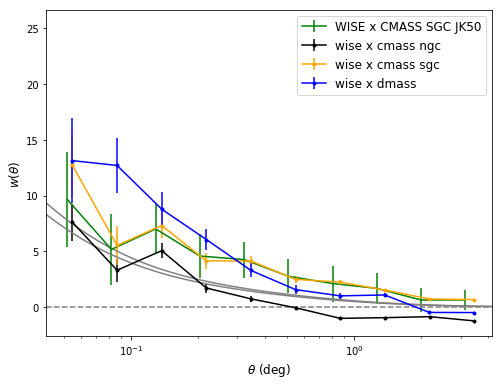

In [12]:

#DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_sgc_sys_cp_nz_weight_nbins10_jk100_no2.txt')
DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_sgc_nbins10_binslop05_jk100.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

#DAT = np.loadtxt(actdir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100_no2.txt')
DAT = np.loadtxt(actdir+'acf_cross_wise_x_dmass_weight_pcut01_nbins10_jk100_no2.txt')
meanr2, xi2, xi_err2 = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt(actdir+'acf_cross_wise_x_cmass_full_sys_cp_nz_weight_nbins10_jk100_no2.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_wise_x_cmass_sgc.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, 1000*xi, yerr = 1000*xi_err, fmt = '-g', label='WISE x CMASS SGC JK50')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-g', label='WISE x DMASS pcut01')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
#ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = 'r.', label='WISE x cmass(sgc)')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='WISE x cmass(sgc)')


ax.plot(theta_th, 1000*theory_wise_cmass_full, color='grey', ls='-')
ax.plot(theta_th, 1000*theory_wise_cmass_sgc, color='grey', ls='-')

ax.errorbar(rmean_ngc, 1000*xi_ngc, yerr = 1000*sigma_xi_ngc, fmt = '.-k', label='wise x cmass ngc ')
ax.errorbar(rmean_sgc, 1000*xi_sgc, yerr = 1000*sigma_xi_sgc, fmt = '.-', color = 'orange', label='wise x cmass sgc')
ax.errorbar(rmean_dmass, 1000*xi_dmass, yerr = 1000*sigma_xi_dmass, fmt = '.-', color = 'blue', label='wise x dmass')
#chisqr = np.sum( (xi4-xi3)**2/xi_err3**2 )*1./xi3.size

chisqr = np.sum( (xi_sgc-xi_dmass)**2/(sigma_xi_dmass**2 + sigma_xi_sgc**2 ))*1./xi_dmass.size
chisqr2 = np.sum( (xi_ngc-xi_dmass)**2/(sigma_xi_dmass**2 + sigma_xi_ngc**2 ))*1./xi_dmass.size
                
#chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size
print chisqr, chisqr2

ax.set_xlim(2.5/60., 250/60.)
#ax.text(1.2, 0.008, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.text(1.2, 0.006, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

#fig.savefig(actdir+'/acf_wise.pdf' )